# ***Introduction***


The goal of this study is to predict the output feature with supervised learning methods such as KNN , SVM, Logistic Regression ...

# ***Data Preprocessing***

Let's import libraries :

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import io
import numpy
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier,GradientBoostingClassifier

In [65]:
import warnings
warnings.filterwarnings('ignore')

and load our dataset:

In [3]:
data = pd.read_csv("Heart Attack Analysis & Prediction Dataset.csv", delimiter=',')

let's discover it :

In [4]:
data.shape

(303, 14)

In [5]:
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [7]:
data.isnull().sum()

,0
age,0
sex,0
cp,0
trtbps,0
chol,0
fbs,0
restecg,0
thalachh,0
exng,0
oldpeak,0


In [8]:
print(data['output'].unique())

[1 0]


In [9]:
from scipy.stats import shapiro
stat, p = shapiro(data)
print(f"Shapiro-Wilk Test : p-value = {p}")
if p > 0.05 :
    print("Data likely follows a normal distribution")
else :
    print("Data does not follow a normal distribution")

Shapiro-Wilk Test : p-value = 1.1477127243012662e-70
Data does not follow a normal distribution


MinMaxScaler is better when the data does't follow normal distribution, later i'll use it for normalisation

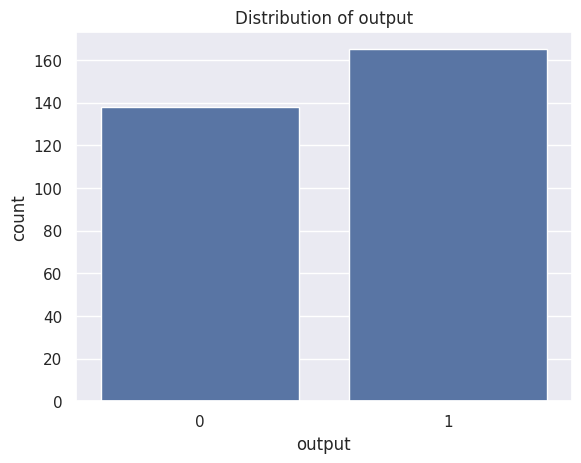

In [10]:
sns.countplot(x=data['output'])
plt.title("Distribution of output")
plt.show()

In [11]:
print(data.groupby('output').size())

output
0    138
1    165
dtype: int64


as you can see from previous visualization the dataset is slightly imbalanced

In [12]:
X = data.drop('output', axis=1)
y = data['output']

Let's split the dataset into train and test sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)

Now , it's time for scaling , as mentioned above i'm going to use MinMaxScaler

In [14]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train.shape

(242, 13)

Let's balance the dataset

In [15]:
undersampler = RandomUnderSampler(random_state=52)
X_downsampled, y_downsampled = undersampler.fit_resample(X_train, y_train)

In [16]:
print("Distribution after downsampling :", Counter(y_downsampled))

Distribution after downsampling : Counter({0: 108, 1: 108})


In [17]:
smote = SMOTE(random_state=52)
X_resampled, y_resampled = smote.fit_resample(X_downsampled, y_downsampled)

In [18]:
print("Distribution after SMOTE :", Counter(y_resampled))

Distribution after SMOTE : Counter({0: 108, 1: 108})


In [19]:
X_resampled.shape

(216, 13)

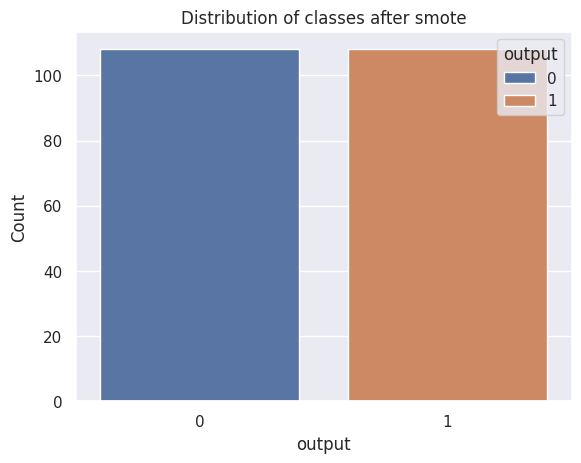

In [20]:
df_downsampled = pd.DataFrame(X_resampled, columns=X_train.columns)
df_downsampled['output'] = y_resampled

sns.countplot(data=df_downsampled, x='output', hue='output')
plt.title('Distribution of classes after smote')
plt.xlabel('output')
plt.ylabel('Count')
plt.show()

# ***Modeling***

## ***Plan***

In this section, I will apply a range of classification algorithms and assess their performance using various evaluation metrics.
 To enhance the accuracy and robustness of the models, I will employ **GridSearch** with cross-validation after training each model.
 This methodology allows for an exhaustive search across a predefined set of hyperparameters, ensuring the identification of the optimal combination that maximizes the model’s performance.
By utilizing cross-validation, we further ensure that the model generalizes well to unseen data, reducing the risk of overfitting.

Finally, I will compare the performance of all the algorithms applied, and select the model that demonstrates the best predictive capability on the dataset.


## ***1/ KNN***

Text(0, 0.5, 'Error')

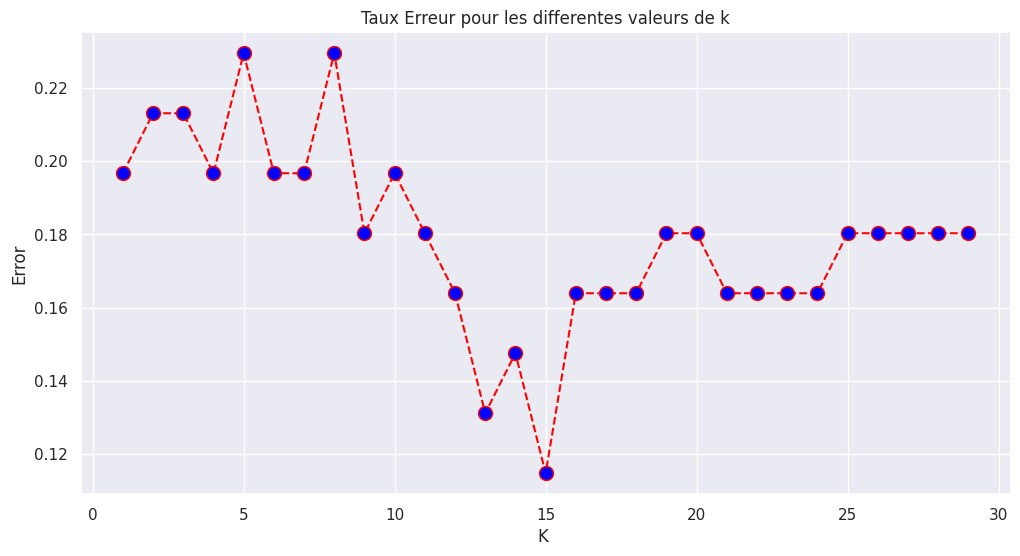

In [21]:
error = []
for i in range(1, 30):
    knn = KNeighborsClassifier(i,metric='manhattan')
    knn_model = knn.fit(X_resampled, y_resampled)
    pred_i = knn_model.predict(X_test)
    error.append(np.mean(pred_i != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taux Erreur pour les differentes valeurs de k')
plt.xlabel('K ')
plt.ylabel('Error')

In [22]:
best_k_error = error.index(min(error)) + 1
best_error = min(error)

print(f"The best K is : {best_k_error} with an error rate of : {best_error:.4f}")

The best K is : 15 with an error rate of : 0.1148


In [23]:
knn = KNeighborsClassifier(n_neighbors=best_k_error, weights='distance',metric='manhattan')
knn.fit(X_resampled, y_resampled)

KNeighborsClassifier(metric='manhattan', n_neighbors=15, weights='distance')

In [24]:
predictions = knn.predict(X_test)

In [25]:
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

print('Accuracy of K-NN classifier on train set: {:.2f}'
     .format(knn.score(X_resampled, y_resampled)))

print("\nRapport de classification :")
print(classification_report(y_test, predictions))

print("\nMatrice de confusion :")
print(confusion_matrix(y_test, predictions))

Accuracy of K-NN classifier on test set: 0.87
Accuracy of K-NN classifier on train set: 1.00

Rapport de classification :
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.90      0.84      0.87        31

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61


Matrice de confusion :
[[27  3]
 [ 5 26]]


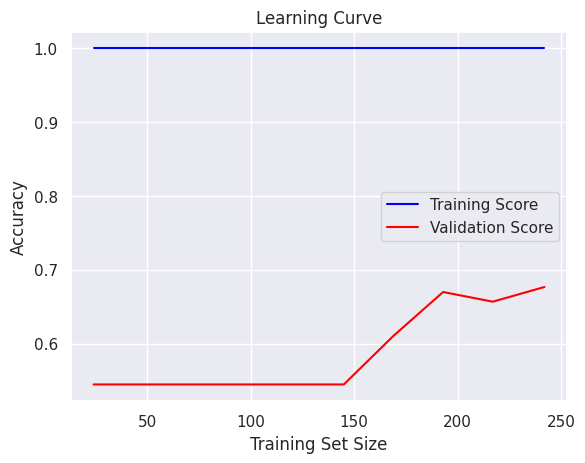

In [26]:
train_sizes, train_scores, test_scores = learning_curve(
    knn, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.plot(train_sizes, test_mean, label="Validation Score", color="red")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

#### ***Conclusion of KNN***
The learning curve shows the KNN model's performance with increasing training set sizes. The training accuracy remains consistently high ~100% , indicating the model fits the training data well. However, the validation accuracy starts low and improves as the training set size increases, reducing overfitting. This suggests that the model generalizes better with more data, though the gap between training and validation scores indicates room for improvement. To enhance performance, I will perform grid search to optimize hyperparameters. Overall, the model shows potential but requires tuning and evaluation to achieve better generalization.

In [27]:
param_grid = {
    'n_neighbors': list(range(1, 40)),
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']}

knn2 = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn2, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_resampled, y_resampled)

print(f"best hyperparameters are : {grid_search.best_params_}")
print(f"best score of cross validation : {grid_search.best_score_}")

Fitting 5 folds for each of 156 candidates, totalling 780 fits
best hyperparameters are : {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'uniform'}
best score of cross validation : 0.8563424947145878


## ***2/ SVM***

In [33]:
svm_model = SVC(kernel='linear',C=10, random_state=42)
svm_model.fit(X_resampled, y_resampled)

y_pred = svm_model.predict(X_test)

print("Accuracy of SVM on test set:", accuracy_score(y_test, y_pred))
print('Accuracy of SVM on train set: {:.2f}'
     .format(svm_model.score(X_resampled, y_resampled)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy of SVM on test set: 0.8360655737704918
Accuracy of SVM on train set: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84        30
           1       0.86      0.81      0.83        31

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61


Confusion Matrix:
 [[26  4]
 [ 6 25]]


The SVM model achieves 84% training accuracy and 83% test accuracy , showing good generalization with minimal overfitting
While performance is consistent ,hyperparameter tuning could further improve accuracy .
Overall , the model performs well as a baseline .

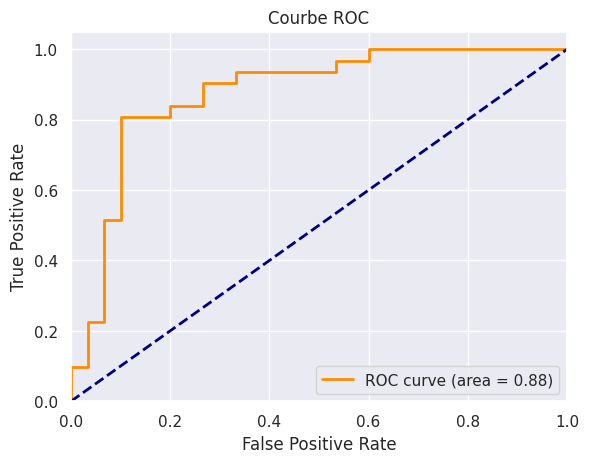

In [34]:
y_prob = svm_model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()


The ROC curve plots the True Positive Rate against the False Positive Rate  at various classification thresholds.

The orange curve represents the model's performance, and the blue diagonal line is the baseline for random guessing.

The Area Under the Curve AUC is 0.88, indicating that the model has good discriminative ability.

AUC values closer to 1 imply better performance, while values around 0.5 suggest random predictions.

In this case, the model performs well, as the curve is significantly above the baseline.

In [ ]:
params_grid = {
    'C': [0.01, 0.1, 1, 10,100],
    'class_weight': [None, 'balanced'],
    'decision_function_shape': ['ovr', 'ovo'],
    'gamma': [1e-3, 1e-4],
    'kernel':['rbf','linear']
}

grid_search = GridSearchCV(SVC( random_state=42), params_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_resampled,y_resampled)

print(f"Best parameters found: {grid_search.best_params_}")
print('Best score for training data:', grid_search.best_score_, "\n")

Best parameters found: {'C': 10, 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'gamma': 0.001, 'kernel': 'linear'}
Best score for training data: 0.8053911205073996 



## ***3/ Logistic Regression***

In [ ]:
C_values = [0.01, 0.1, 1, 10, 100]

results = {}

for C in C_values:
    lr_model = LogisticRegression(C=C, max_iter=1000,  random_state=52)
    lr_model.fit(X_resampled, y_resampled)
    y_pred = lr_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[C] = {
        'model': lr_model,
        'accuracy': accuracy
    }

In [ ]:
print("Results of Logistic Regression Classification:")
for C, result in results.items():
    print(f"C = {C}, Accuracy: {result['accuracy']:.4f}")

Results of Logistic Regression Classification:
C = 0.01, Accuracy: 0.8197
C = 0.1, Accuracy: 0.8361
C = 1, Accuracy: 0.8689
C = 10, Accuracy: 0.8525
C = 100, Accuracy: 0.8525


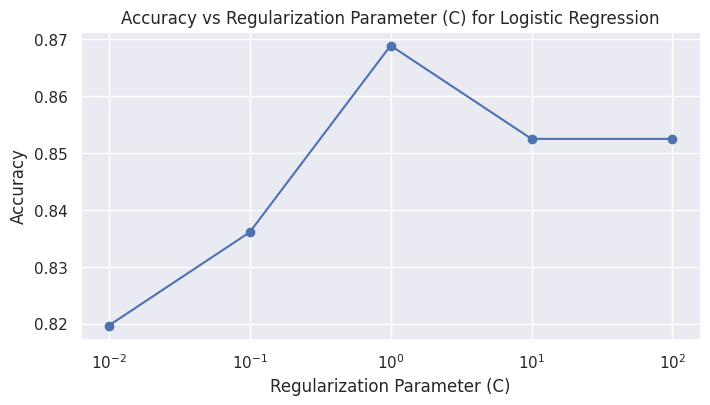

In [ ]:
accuracies = [result['accuracy'] for C, result in results.items()]

plt.figure(figsize=(8, 4))
plt.plot(C_values, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Regularization Parameter (C) for Logistic Regression')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Best Parameters: {'C': 0.1, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Accuracy of the best model: 0.8361
Output type used: Softmax (Multinomial)


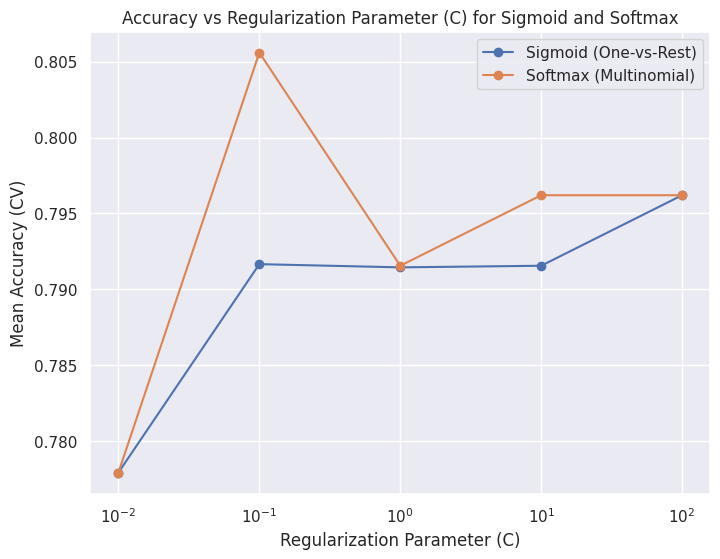

In [36]:
C_values = [0.01, 0.1, 1, 10, 100]
output_types = ['ovr', 'multinomial']
param_grid = {
    'C': C_values,
    'multi_class': output_types,
    'solver': ['lbfgs']
}

lr = LogisticRegression(max_iter=1000, random_state=52)

grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best model: {accuracy:.4f}")

y_prob = best_model.predict_proba(X_test)
if best_params['multi_class'] == 'multinomial':
    output_type = "Softmax (Multinomial)"
else:
    output_type = "Sigmoid (One-vs-Rest)"
print(f"Output type used: {output_type}")

results = grid_search.cv_results_
sigmoid_accuracies = [results['mean_test_score'][i] for i in range(len(results['params'])) if results['params'][i]['multi_class'] == 'ovr']
softmax_accuracies = [results['mean_test_score'][i] for i in range(len(results['params'])) if results['params'][i]['multi_class'] == 'multinomial']

plt.figure(figsize=(8, 6))
plt.plot(C_values, sigmoid_accuracies, label='Sigmoid (One-vs-Rest)', marker='o')
plt.plot(C_values, softmax_accuracies, label='Softmax (Multinomial)', marker='o')
plt.xscale('log')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Mean Accuracy (CV)')
plt.title('Accuracy vs Regularization Parameter (C) for Sigmoid and Softmax')
plt.legend()
plt.grid(True)
plt.show()


From the visualization , it seems that Softmax performs better than sigmoid in terms of mean accuracy across most values of the regularization parameter C .Specifically :
The Softmax curve reaches a higher peak accuracy compared to Sigmoid.
Softmax maintains better performance stability for certain ranges of C.

## ***4/ Decision Tree***

In [ ]:
dct_model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=2 ,min_samples_leaf=5, random_state=52)
dct_model.fit(X_resampled, y_resampled)
preds = dct_model.predict(X_test)

In [ ]:
train_preds = dct_model.predict(X_resampled)

test_report = classification_report(y_test,preds)
train_accuracy = accuracy_score(y_resampled, train_preds)
test_accuracy = accuracy_score(y_test, preds)

print(f"Accuracy on Train Data: {train_accuracy:.4f}")
print(f"Accuracy on Test Data: {test_accuracy:.4f}")
print("\nClassification Report for Test Data:")
print(test_report)

print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

Accuracy on Train Data: 0.8981
Accuracy on Test Data: 0.7377

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        30
           1       0.74      0.74      0.74        31

    accuracy                           0.74        61
   macro avg       0.74      0.74      0.74        61
weighted avg       0.74      0.74      0.74        61

Confusion Matrix:
 [[22  8]
 [ 8 23]]


The significant Gap between training and test accuarcy suggests that the model  is overfitting, capturing the noise or overly specific patterns that do not generalize well to unseen data .

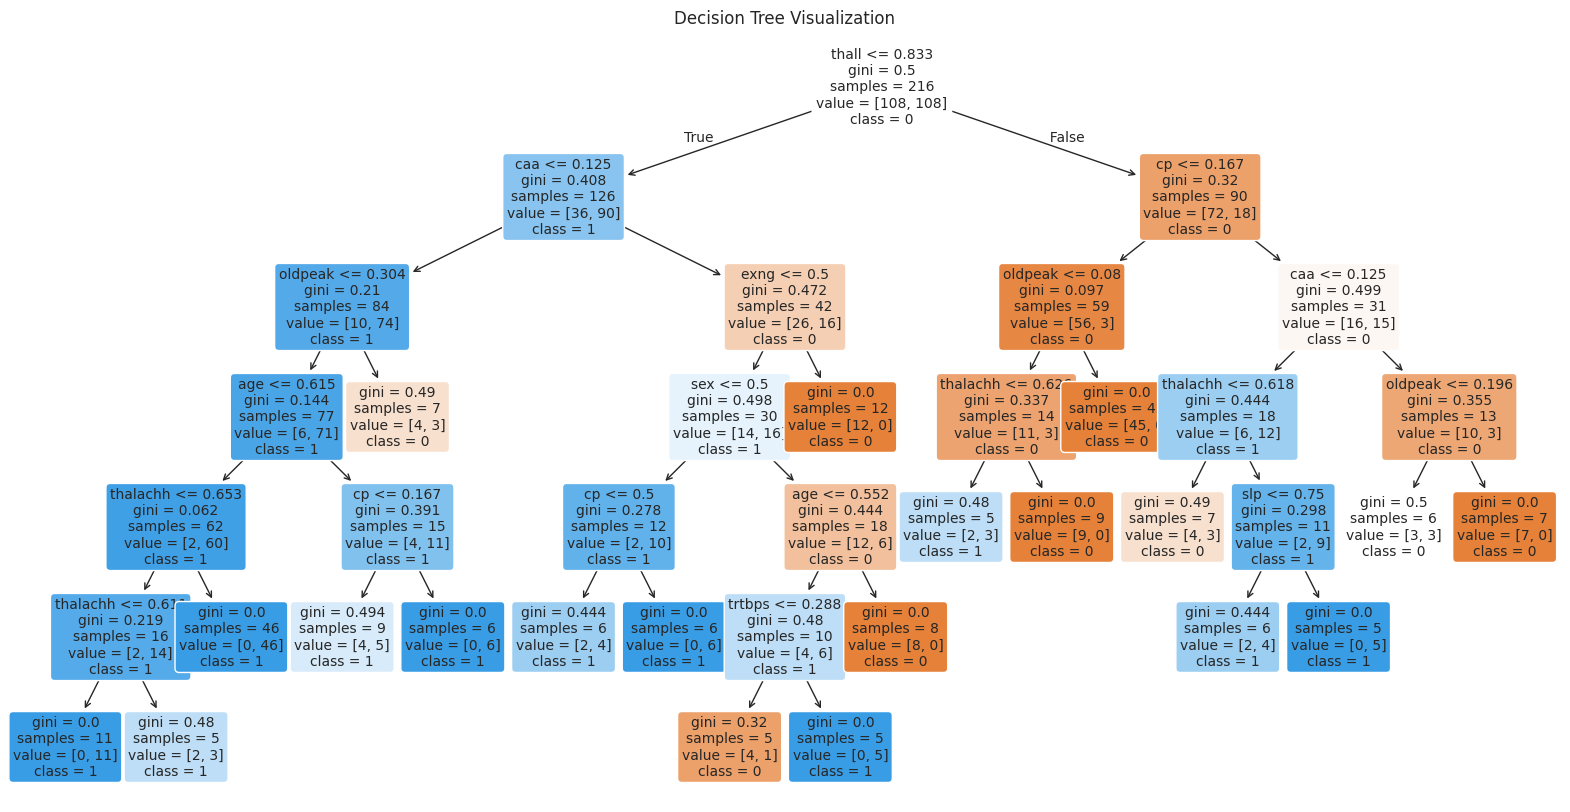

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(
    dct_model,
    feature_names=X_resampled.columns if hasattr(X_resampled, 'columns') else None,
    class_names=dct_model.classes_.astype(str),
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()

The decision Tree appears complex , likely with a deep structure that may contribute to overfitting .

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': list(range(2, 20)) ,
    'min_samples_leaf':list(range(1, 15))
}

DCT_model = DecisionTreeClassifier(random_state=52)

grid_search = GridSearchCV(
    estimator=DCT_model,
    param_grid=param_grid,
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_resampled, y_resampled)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

test_preds = best_model.predict(X_test)
test_report = classification_report(y_test, test_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Best Parameters:", best_params)
print(f"Accuracy on Test Data: {test_accuracy:.4f}")
print("\nClassification Report for Test Data:")
print(test_report)
print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))

Fitting 5 folds for each of 2016 candidates, totalling 10080 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Accuracy on Test Data: 0.7377

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        30
           1       0.74      0.74      0.74        31

    accuracy                           0.74        61
   macro avg       0.74      0.74      0.74        61
weighted avg       0.74      0.74      0.74        61

Confusion Matrix:
 [[22  8]
 [ 8 23]]


## ***5/ Random Forest***

In [38]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)
y_pred = rf.predict(X_test)

In [39]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print('Accuracy of rfc classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

print('Accuracy of rfc classifier on train set: {:.2f}'
     .format(rf.score(X_resampled, y_resampled)))

print("Classification Report:\n", classification_report(y_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7705
Accuracy of rfc classifier on test set: 0.77
Accuracy of rfc classifier on train set: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.87      0.79        30
           1       0.84      0.68      0.75        31

    accuracy                           0.77        61
   macro avg       0.78      0.77      0.77        61
weighted avg       0.78      0.77      0.77        61

Confusion Matrix:
 [[26  4]
 [10 21]]


 Train accuracy is 100%, while test accuracy is lower. This signals overfitting.

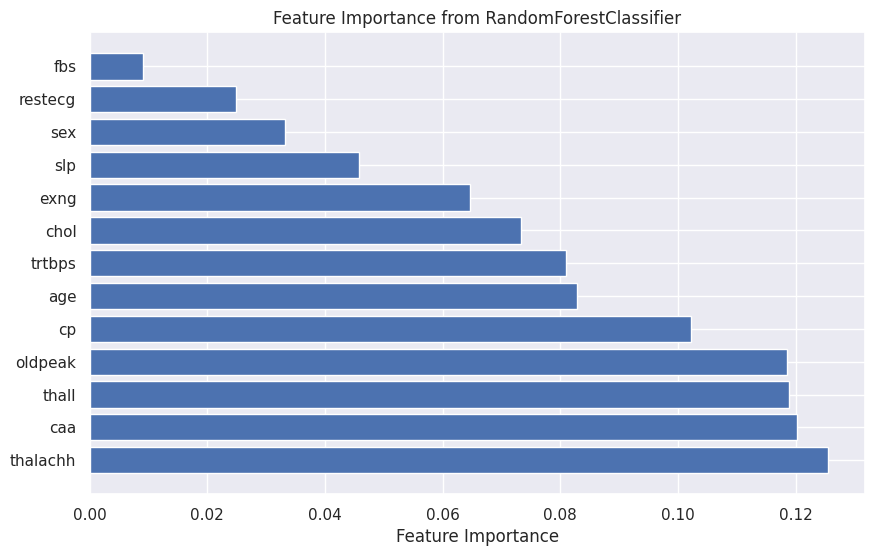

In [40]:
feature_importances = rf.feature_importances_

feature_names = X_resampled.columns  # For pandas DataFrame

indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance from RandomForestClassifier')
plt.barh(range(len(feature_importances)), feature_importances[indices], align='center')
plt.yticks(range(len(feature_importances)), feature_names[indices])
plt.xlabel('Feature Importance')
plt.show()

This suggests that the "thalachh" : maximum heart rate achieved and "caa" :number of major vessels features are the most significant predictors in this model.

Next Steps for Improvement : GridSearch with Cross Validation

In [43]:
paramgrid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=paramgrid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(X_resampled, y_resampled)

best_params = grid_search.best_params_
best_model_ = grid_search.best_estimator_
testing_accuracy = best_model_.score(X_test, y_test)

print("Best parameters found by Grid Search:\n", best_params)
print('Train Accuracy with Best Parameters:', grid_search.best_score_, "\n")
print("Test Accuracy with Best Parameters:", testing_accuracy)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found by Grid Search:
 {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Train Accuracy with Best Parameters: 0.8426004228329811 

Test Accuracy with Best Parameters: 0.819672131147541


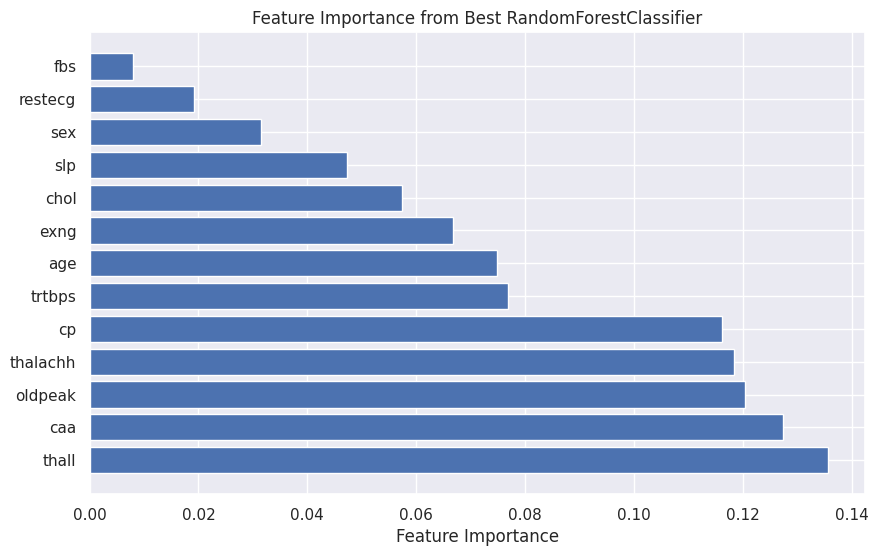

In [46]:
feature_importances = best_model_.feature_importances_

features = X_resampled.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance')

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance from Best RandomForestClassifier')
plt.xlabel('Feature Importance')
plt.show()

After doing the GridSearch and finding the best model, we can conclude that :

thall :thalassemia and caa: number of major vessels are the most important features for prediction .

## ***6/ AdaBoost***

In [63]:
adaboost_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.1,
    random_state=52
)

adaboost_clf.fit(X_resampled, y_resampled)
adaboost_pred = adaboost_clf.predict(X_test)
train_ada=adaboost_clf.predict(X_resampled)

test_ada_report=classification_report(y_test,adaboost_pred)
train_ada=accuracy_score(y_resampled,train_ada)
test_ada=accuracy_score(y_test,adaboost_pred)


print(f"Accuracy of adaboost  on test set: {test_ada:.4f}")
print(f"Accuracy of adaboost on train set: {train_ada:.2f}")

print("Classification Report:\n",test_ada_report)
print("Confusion Matrix:\n", confusion_matrix(y_test, adaboost_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy of adaboost  on test set: 0.8361
Accuracy of adaboost on train set: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84        30
           1       0.86      0.81      0.83        31

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61

Confusion Matrix:
 [[26  4]
 [ 6 25]]


The AdaBoost model shows good performance, with an accuracy of 83% on the test set and 88% on the training set, indicating slight overfitting.
The confusion matrix reveals 6 false negatives and 4 false positives. To improve, reducing overfitting and fine-tuning the hyperparameters by GridSearch Cross Validation

In [64]:
adaboost_clf1 = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(),
    random_state=52
)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=adaboost_clf1,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_resampled, y_resampled)

best_params = grid_search.best_params_
print("Best parameters found by Grid Search:\n", best_params)

best_adaboost_clf = grid_search.best_estimator_
train_predictions = best_adaboost_clf.predict(X_resampled)
test_predictions = best_adaboost_clf.predict(X_test)

train_accuracy = accuracy_score(y_resampled, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print("AdaBoost Train Accuracy:", train_accuracy)
print("AdaBoost Test Accuracy:", test_accuracy)

print("\nClassification Report on Test Data:\n")
print(classification_report(y_test, test_predictions))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters found by Grid Search:
 {'estimator__max_depth': 1, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'learning_rate': 0.01, 'n_estimators': 200}
AdaBoost Train Accuracy: 0.8564814814814815
AdaBoost Test Accuracy: 0.8360655737704918

Classification Report on Test Data:

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        30
           1       0.86      0.81      0.83        31

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



# ***Comparative Study***

Classification Report for Logistic Regression  :
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        30
           1       0.87      0.87      0.87        31

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

--------------------------------------------------
Classification Report for Decision Tree  :
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        30
           1       0.74      0.74      0.74        31

    accuracy                           0.74        61
   macro avg       0.74      0.74      0.74        61
weighted avg       0.74      0.74      0.74        61

--------------------------------------------------
Classification Report for Random Forest  :
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        30


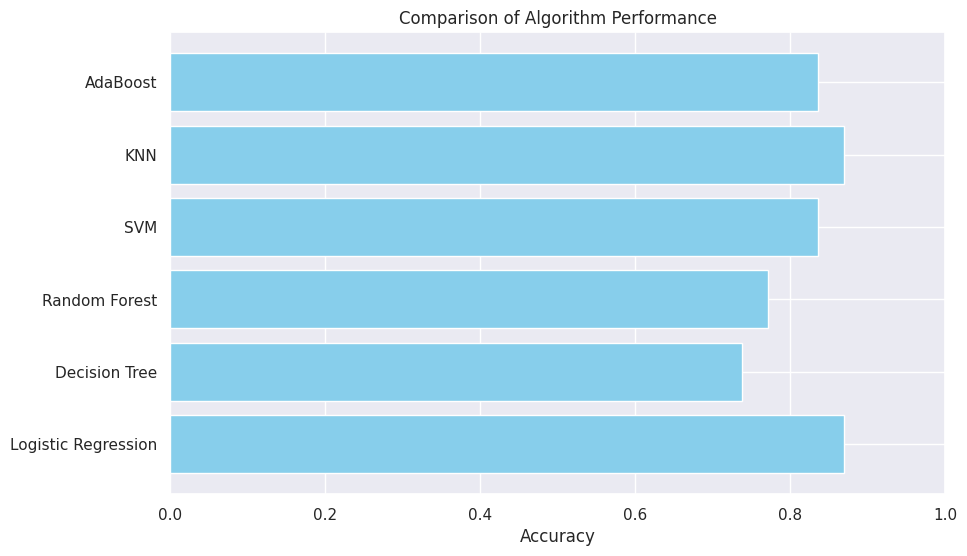

In [80]:
from sklearn.model_selection import train_test_split, cross_val_score

models = {
    "Logistic Regression": LogisticRegression(C=1, max_iter=1000,  random_state=52),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=2 ,min_samples_leaf=5, random_state=52),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='linear',C=10, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=best_k_error, weights='distance',metric='manhattan'),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.1,
    random_state=52)
}
results = []

for name, model in models.items():
  try:
        model.fit(X_resampled, y_resampled)

        # Predict on the test set
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        results.append((name, accuracy))

        print(f"Classification Report for {name}  :")
        print(classification_report(y_test, y_pred))
        print('-' * 50)

  except Exception as e:
        print(f"Error with model {name}: {e}")

print(f"Classification Report for {name}:")
print(classification_report(y_test, y_pred))
print('-' * 50)

model_names = [result[0] for result in results]
accuracies = [result[1] for result in results]

plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Comparison of Algorithm Performance')
plt.xlim(0, 1)
plt.show()


The comparative analysis of classification algorithms reveals varying performances across the models evaluated on the test dataset.
#### **Logistic Regression**:
Precision, recall, and f1-score are consistently 0.87 for both classes, resulting in an overall accuracy of 87%.
This model demonstrates robust and balanced performance.
#### **Decision Tree** :
This model achieves a lower accuracy of 74%, with similar values for precision and recall, indicating limited generalization capabilities on the data.
#### **Random Forest**:
The accuracy reaches 77%, with better performance for class 0 (precision of 0.84) compared to class 1 (precision of 0.72). This suggests a slight imbalance in class predictions.
#### **SVM** :
SVM achieves an accuracy of 84%, with balanced performance between both classes.
#### **KNN** :
With an accuracy of 87%, this model ranks among the best, showing high values for precision and recall but it has an overfitting issue .
#### **AdaBoost**:
AdaBoost also achieves an accuracy of 84%, similar to SVM, with slightly lower performance compared to KNN or Logistic Regression.

### ****Conclusion****:

The Logistic Regression and KNN models deliver the best performance with an accuracy of 87%, followed by SVM and AdaBoost 84%.
In contrast, Decision Tree and Random Forest exhibit more modest performance.

The final choice will be based not only on its evaluation with accuracy but also on its ability to generalize effectively, with particular consideration given to minimizing overfitting and ensuring robust performance across both training and test datasets.